In [1]:
import torch

from reggae.data_loaders.datasets import P53Data
from reggae.gp.variational import SingleLinearLFM, TranscriptionalTrainer
from reggae.utilities import save, load
from reggae.plot.variational_plotters import Plotter

from matplotlib import pyplot as plt


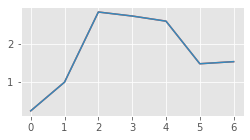

In [2]:
dataset = P53Data(replicate=0)
num_genes = 5
num_tfs = 1
num_replicates = 1
num_times = 7

m_observed = torch.stack([
    dataset[i][1] for i in range(num_genes*num_replicates)
]).view(num_replicates, num_genes, num_times)

t_inducing = torch.linspace(0, 12, 7, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(0, 12, 7).view(-1)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float64)


plt.figure(figsize=(4, 2))
plt.plot(dataset[0][1])
plt.plot(m_observed[0, 0])

In [11]:
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float64)

In [3]:
#ExponentialLFM
model = SingleLinearLFM(num_genes, num_tfs, t_inducing, dataset, fixed_variance=dataset.variance,
                        learn_inducing=False, num_samples=50, kernel_scale=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
trainer = TranscriptionalTrainer(model, optimizer, dataset)
plotter = Plotter(model, dataset.gene_names)

C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models\model.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=learn_inducing)


### Outputs prior to training:

C:\Users\Jacob\Documents\proj\reggae\reggae\plot\variational_plotters.py:104: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


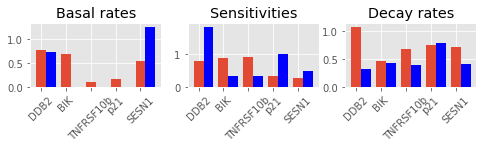

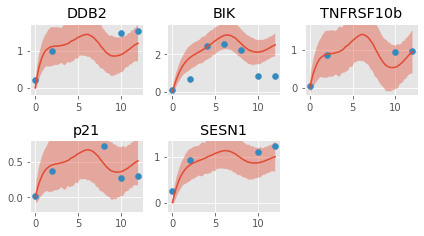

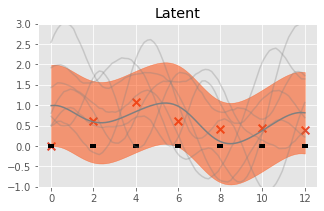

In [4]:
rtol = 1e-3
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol
}

plotter.plot_kinetics()
plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)

In [ ]:
tol = 5e-3
import time
start = time.time()

output = trainer.train(50, rtol=tol, atol=tol/10,
                       report_interval=5, plot_interval=5)
end = time.time()
print(end - start)


Epoch 101/150 - Loss: 11.55 (7.25 4.30) λ: 1.238 b: 0.66 d 0.55 s: 0.92


### Outputs after training

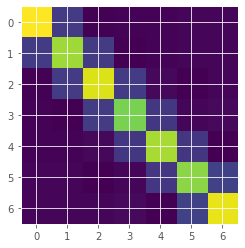

In [8]:
S = torch.tril(torch.stack(trainer.cholS).squeeze())
S = torch.matmul(S, S.transpose(1, 2))
plt.imshow(S[99])

C:\Users\Jacob\Documents\proj\reggae\reggae\plot\variational_plotters.py:104: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


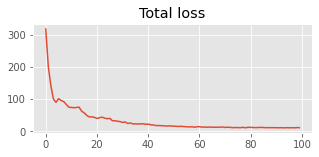

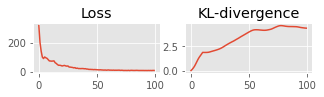

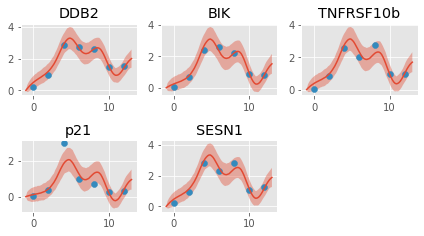

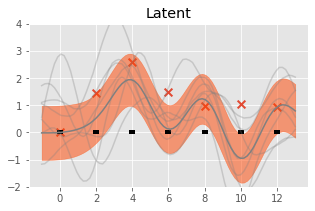

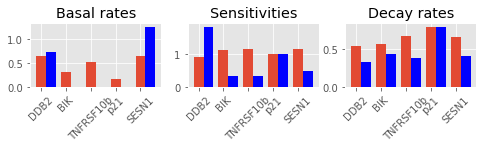

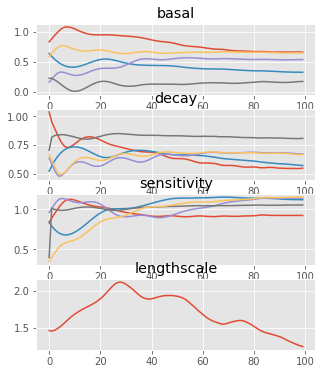

In [12]:
plotter.plot_losses(trainer, last_x=100)
plotter.plot_outputs(t_predict, replicate=0, ylim=(0, 3), t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 4), plot_barenco=True, plot_inducing=False)
plotter.plot_kinetics()
plotter.plot_convergence(trainer)

In [8]:
save(model, 'variational_linear')

In [9]:
do_load = False
if do_load:
    model = load('variational_linear', SingleLinearLFM, num_genes, num_tfs,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = TranscriptionalTrainer(model, optimizer, dataset)
print(do_load)

False
